# Static Bandits

In [203]:
from collections import defaultdict
#from hyperopt import fmin, tpe, hp, STATUS_OK, Trials
from math import sqrt
import matplotlib.pyplot as plt
%matplotlib inline
import numpy as np
import pandas as pd
from random import random
import random
import scipy.stats as stats
import seaborn as sb

from bandit_classes2 import *

## generating static data

In [27]:
def gen_static_uniform(k = 2):
    return np.random.rand(k)

#print gen_static_uniform(10)
print(gen_static_uniform(10))

[ 0.497357    0.46997848  0.8906853   0.11998914  0.22534754  0.9068703
  0.91548275  0.00287429  0.31995918  0.93097188]


In [28]:
def gen_static_beta(k = 2, a = 1, b = 100):
    return np.random.beta(a, b, k)
    
#print gen_static_beta(10)
print(gen_static_beta(10))

[  3.39226085e-02   1.95054514e-03   1.50898119e-02   8.01303176e-03
   5.96507473e-03   8.07552839e-03   7.34147408e-03   6.40500113e-04
   5.88997371e-05   1.50710305e-02]


## visualizing static data

In [93]:
def plot_static(actual, title='uniform',
                x_range = range(2),
               figsize = (10,5),
               colormap = None,
               axis = None):
    if not axis:
        fig, ax = plt.subplots(figsize=figsize)
    else:
        ax = axis
    ax.set_title(title, fontsize=16)
    ax.set_xlabel('time step', fontsize=14)
    ax.set_ylabel('rewards', fontsize=14)
    ax.grid('off')
    ax.set_axis_bgcolor('white')
    k = actual.shape[0]
    for i in range(k):
        if colormap:
            color = colormap(float(i)/k)
        else:
            color = 'k'
        ax.plot(x_range, [actual[i]]*len(x_range), 
                c=color, alpha=1.0,
                label=str(i)+' actual', linewidth=2)
    #return fig, ax
    #ax.get_xaxis().set_visible(False)
    #ax.get_yaxis().set_visible(False)
    #return labels

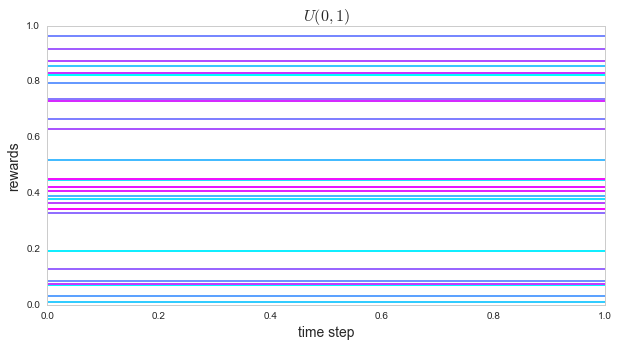

In [202]:
k = 30
actual = gen_static_uniform(k)
plot_static(actual, title=r'$ U(0,1)$', colormap=plt.cm.cool)

(<matplotlib.figure.Figure at 0x10cd08a90>,
 <matplotlib.axes._subplots.AxesSubplot at 0x10d8a5908>)

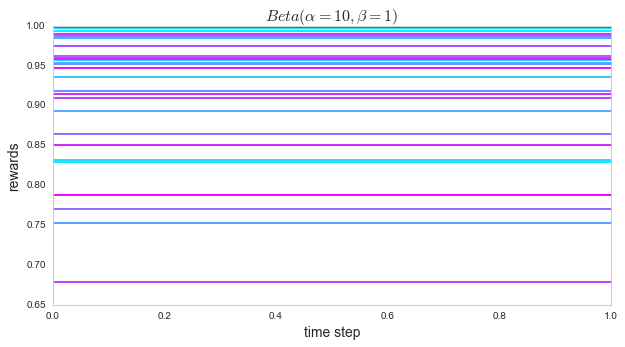

In [72]:
a, b = 10, 1
k = 30
actual = gen_static_beta(k=k, a=a, b=b)
plot_static(actual, title=r'$ Beta(\alpha='+str(a)+r',\beta='+str(b)+')$', colormap=plt.cm.cool)

## visualizing regret

//anaconda/lib/python3.5/site-packages/matplotlib/__init__.py:872: UserWarning: axes.color_cycle is deprecated and replaced with axes.prop_cycle; please use the latter.
  warnings.warn(self.msg_depr % (key, alt_key))
//anaconda/lib/python3.5/site-packages/matplotlib/__init__.py:892: UserWarning: axes.color_cycle is deprecated and replaced with axes.prop_cycle; please use the latter.
  warnings.warn(self.msg_depr % (key, alt_key))


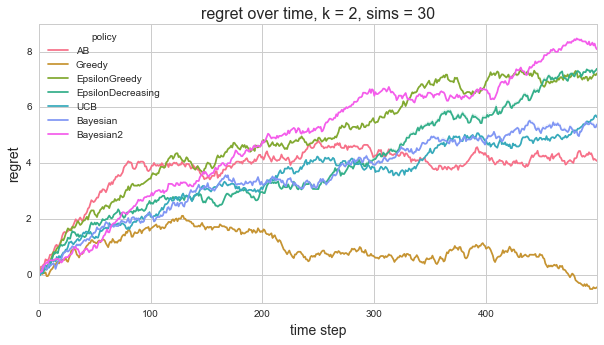

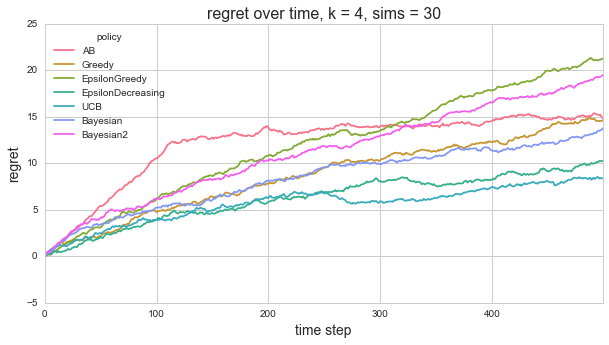

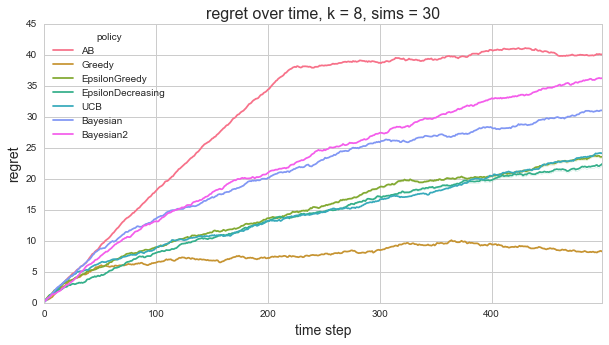

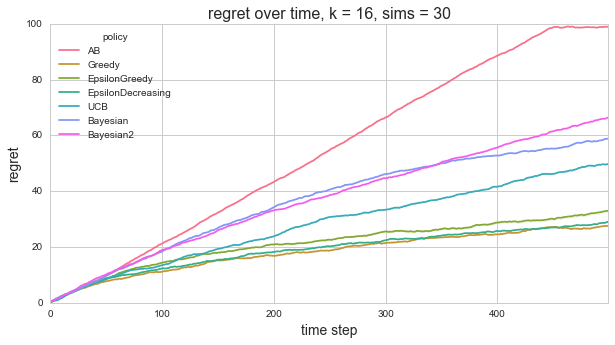

In [201]:
# test static, non-volatile data
def test_static(k = 2, T = 10, 
                actual = None, 
                bandit = None):
    rewards = np.zeros(T)
    expected_values = defaultdict(list) # key: arm_id, value: [(t1, mean), (t2, mean), ...]
    variances = defaultdict(list)# key: arm_id, value: [(t1, var), (t2, var), ...]
    regret = np.zeros(T)
    actual_best = actual.max()
    for t in range(T):
        arm = bandit.choose_arm()
        reward = 0.0
        if actual[arm] > np.random.random():
            reward = 1.0
        rewards[t] = reward
        regret[t] = (t+1)*actual_best - rewards.sum()
        bandit.update(arm, reward)
        for arm_id in bandit.arms.keys():
            expected_values[arm_id].append((t,bandit.get_expected_value(arm_id)))
            variances[arm_id].append((t,bandit.get_variance(arm_id)))
    regret = np.array(regret)
    return rewards, expected_values, variances, regret

def do_sims(bandits, n_sims=10, k=20, T=100, data_gen=gen_static_uniform, 
            params=None):
    if data_gen == gen_static_beta:
        a, b = params['a'], params['b']
    ts = pd.Series(range(T))
    df_final = None
    for sim in range(n_sims):
        if data_gen == gen_static_beta:
            actual = data_gen(k, a, b)
        else:
            actual = gen_static_uniform(k)
        for i, bandit in enumerate(bandits):
            bandit = bandit(k)
            rewards, expected_values, variances, regret = test_static(k, T, actual, bandit)
            rewards = rewards.tolist()
            df = pd.DataFrame(ts, columns=['time'])
            df['policy'] = [bandit.__class__.__name__]*T
            df['regret'] = regret
            df['sim'] = pd.Series([sim]*T)
            if df_final is None:
                df_final = df
            else:
                df_final = pd.concat([df_final, df], ignore_index=True)
    fig, ax = plt.subplots(figsize=(10,5), dpi=200)
    ax.set_title('regret over time, k = '+str(k)+', sims = '+str(n_sims), 
                 fontsize=16)
    sb.set_palette('colorblind')
    sb.set_style("whitegrid")
    sb.tsplot(df_final, time='time', unit='sim', value='regret', 
              condition='policy', ci=0, ax=ax)
    ax.set_xlabel('time step', fontsize=14)
    ax.set_ylabel('regret', fontsize=14)
    
bandits = [AB, Greedy, EpsilonGreedy, EpsilonDecreasing, UCB, Bayesian, Bayesian2]#, Bayesian3]
params = {'a': 2, 'b': 10}
n_sims = 30
T = 500
for k in [2, 4, 8, 16]:
    #do_sims(bandits, n_sims=10, k=k, T=100, data_gen=gen_static_uniform)
    do_sims(bandits, n_sims, k, T, gen_static_beta, params)

# k = 2
# bayes better when data is distributed beta(1,20)
# ucb better when data is distributed beta(1,10)
# ep-decr better when data is distributed beta(1,1)
# ucb better when data is distributed beta(10,1)
# ucb better when data is distributed beta(20,1)

#k = 4
# ucb better when data is distributed beta(1,1)

#k = 10
# ucb better when data is distributed beta(1,1)
# ucb better when data is distributed beta(10,1)
# ucb better when data is distributed beta(1,10)


## plotting bandit beliefs

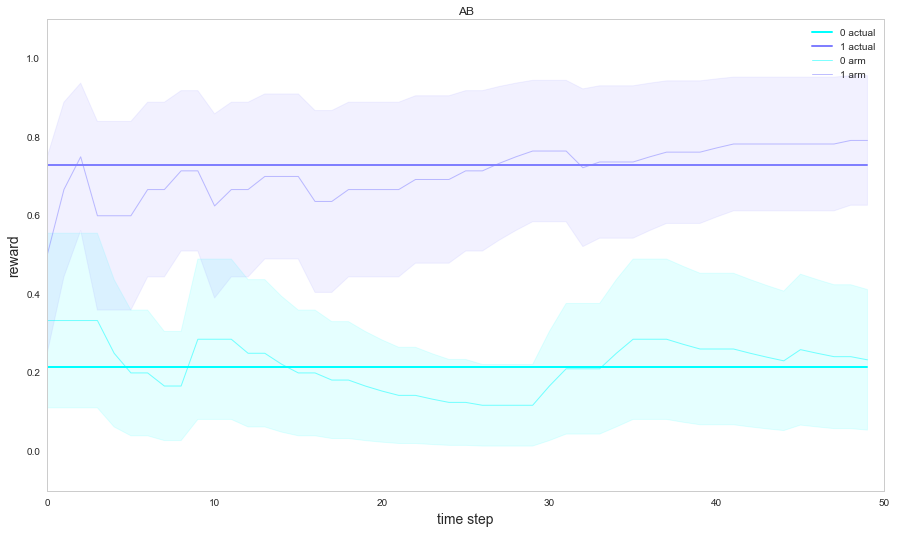

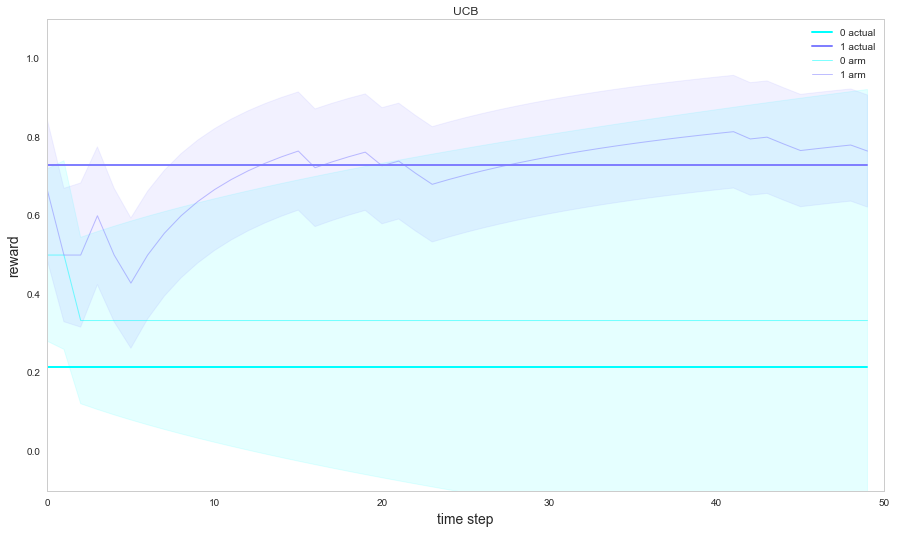

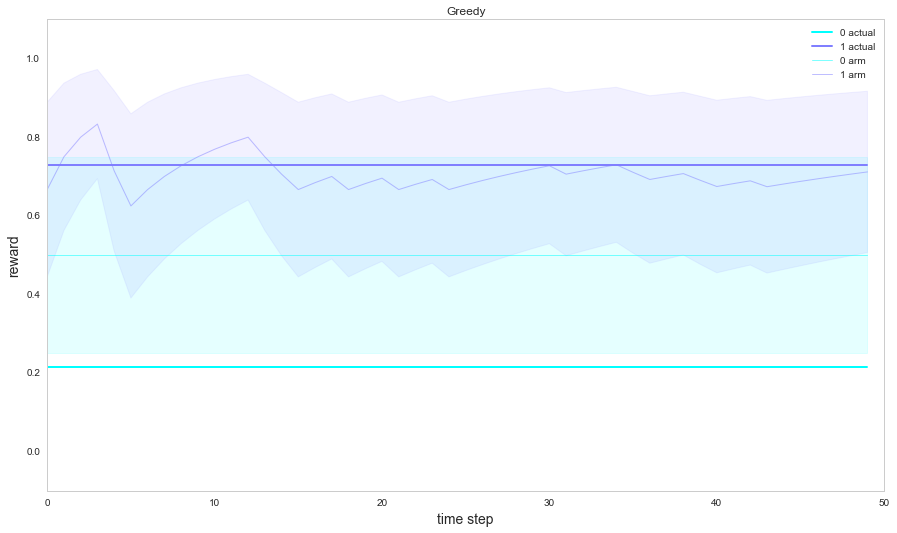

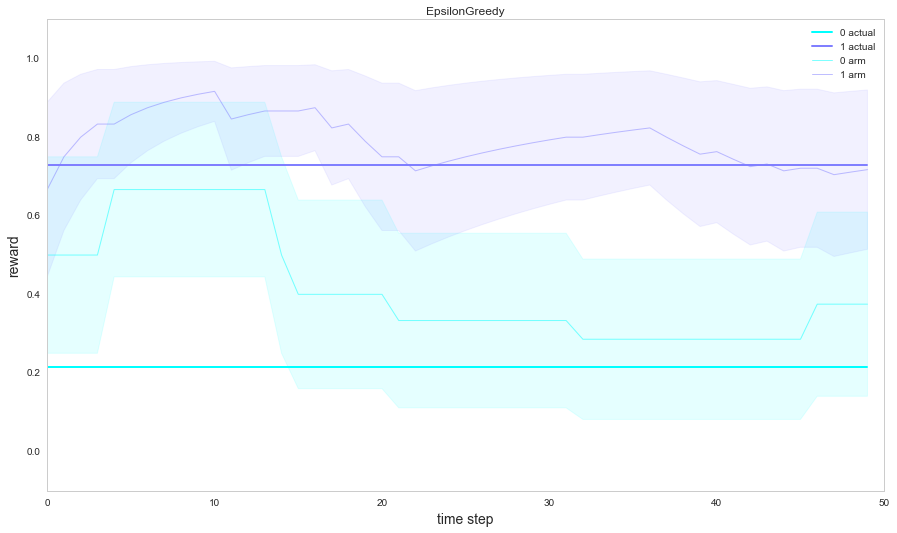

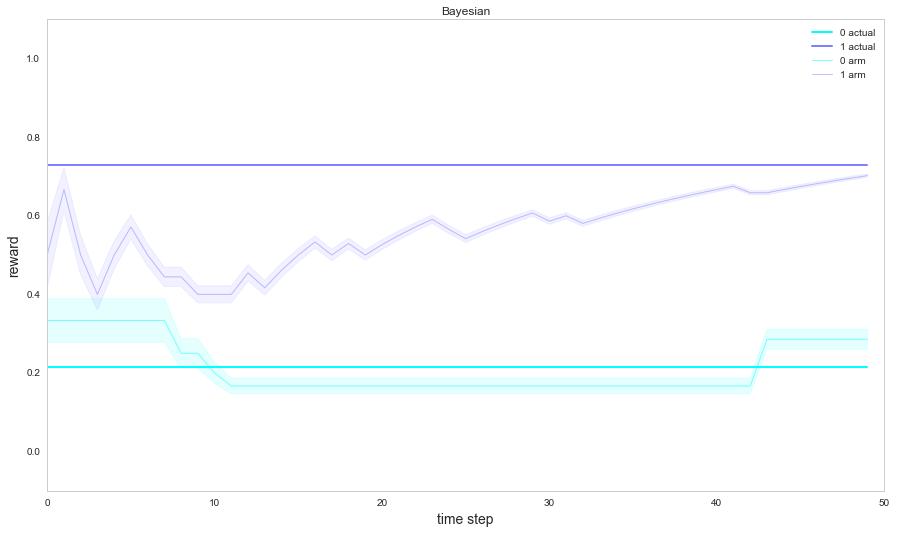

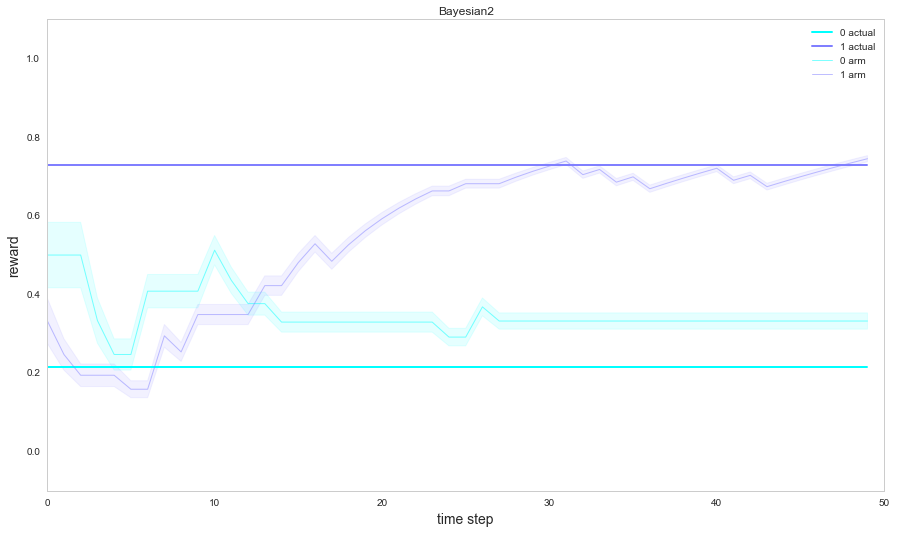

In [194]:
def plot_arm_data_plus_actual_static(expected_values, variances, actual, 
                              #figsize=(10,5), 
                              figsize=(15,8.45),
                              colormap = plt.cm.cool,
                              fig_title='title'):
    #plt.clf()
    fig, ax = plt.subplots(figsize=figsize)
    max_timestep = int(max([lst[-1][0] for (k,lst) in expected_values.items()])) + 1
    #print(max_timestep)
    plot_static(actual, axis=ax, colormap=colormap, x_range=range(max_timestep))
    ax.set_title(fig_title);
    ax.grid('off')
    ax.set_ylim(-0.1, 1.1)
    ax.set_xlabel('time step'); ax.set_ylabel('reward')
    k = len(expected_values.keys())
    for i, arm_id in enumerate(expected_values.keys()):
        color = colormap(i/float(k))
        xs, means = zip(*expected_values[arm_id])
        means = np.array(means)
#        ys = np.array([e[i][0] for e in arm_data])
#        err = np.array([(e[i][1]) for e in arm_data])
        h = ax.plot(xs, means, color=color, alpha=0.5, label=str(i)+' arm', linewidth=1)
#        ax.fill_between(xs, ys+err, ys-err, color=color, alpha=0.35, linewidth=1)
        xs, ys = zip(*variances[arm_id])
        ys = np.array(ys)
        #ys = ys/2
        ax.fill_between(xs, means+ys, means-ys, color=color, alpha=0.1, linewidth=1)
    ax.legend(loc='best')

def demo_bandits():
    k, T = 2, 50
    actual = gen_static_uniform(k)
    bandits = [AB(k),
               UCB(n_arms=k, delta=0.05),
               Greedy(k),
               EpsilonGreedy(k, 0.1),
               Bayesian(k),Bayesian2(k)]
    for b in bandits:
        rewards, expected_values, variances, regret = test_static(k, T, actual, b)
        #print(expected_values)
        bandit_name = b.__class__.__name__
        plot_arm_data_plus_actual_static(expected_values, variances, actual, fig_title=bandit_name)
        #print(b, variances)
demo_bandits()

## parameter tuning using hyperopt

In [181]:
import hyperopt as hp
space_epsilon_greedy = {
    'e': hp.uniform('e', 0.0, 1.0)
}
k, T = 20, 500
#k, T = 3, 100

def f(a):
    e = a['e']
    #actual = gen_static_uniform(k, T)
    actual = gen_static_beta(k, a=10, b=1)
    #print actual
    bandit = EpsilonGreedy(n_arms=k, epsilon=e)
    rewards, means, variances, regret = test_static(k, T, actual, bandit)
    #print regret
    return {'loss': regret.mean(), 'status': STATUS_OK}

trials = Trials()
best = fmin(f, space_epsilon_greedy, algo=tpe.suggest, max_evals=1000, trials=trials)
#print best
#for trial in trials.trials:
#    print trial
f, ax = plt.subplots(figsize=(5,5))
xs = [t['tid'] for t in trials.trials]
#ys = [t['result']['loss'] for t in trials.trials]
cmap = plt.cm.jet
xs = np.array([t['misc']['vals']['e'] for t in trials.trials]).ravel()
ys = [t['result']['loss'] for t in trials.trials]
#print ys
xs, ys = zip(*sorted(zip(xs, ys)))
#print xs
#print np.min(ys), np.max(ys)
ax.set_xlim(xs[0]-0.1, xs[-1]+0.1)
#ax.scatter(xs, ys, s=20, linewidth=0.01, alpha=0.85, c=map(lambda x: cmap(x), xs)
ax.scatter(xs, ys, s=20, linewidth=0.01, alpha=0.5)
ax.set_title('epsilson')
# 500 evals
# k, T = 2, 500: {'e': 0.09747575020458313}
# k, T = 4, 500: {'e': 0.03270717406841881}
# k, T = 10, 500: {'e': 0.043947921169053654}
# k, T = 20, 500: {'e': 0.000338458854921297}
# k, T = 50, 500: {'e': 3.096403594072899e-05}

# 1000 evals
# k, T = 2, 500: {'e': 0.0003479380548632449}
# k, T = 10, 500: {'e': 0.00014528134554619293}
# k, T = 20, 500: {'e': 0.0010218330670631536}

# beta(1,10)
# k, T = 2, 500: {'e': 0.13245564986616667}
# k, T = 10, 500: {'e': 0.06829021319738379}

# k, T = 20, 500: {'e': 0.15905617104145692}

# beta(10,1)
# k, T = 20, 500: {'e': 0.017869008912391172 }


ImportError: No module named 'hyperopt'

## demos: animal faces and button colors

In [188]:
def test_static_animalfaces(k, T, actual, bandit):
    rewards = []
    arm_data = []
    regret = []
    arms_selected = np.zeros(T)
    for t in range(T):
        arm = bandit.choose_arm()
        arms_selected[t] = arm
        actual_best = np.max(actual)
        reward = 0.0
        if actual[arm] > np.random.random():
            reward = 1.0
        regret.append(actual_best - reward)
        rewards.append(reward)
        #arm_data.append(bandit.get_arm_data())
        bandit.update(arm, reward)
    rewards = np.array(rewards)
    arm_data = np.array(arm_data)
    regret = np.array(regret)
    return rewards, arm_data, regret, arms_selected

def demo_bandits_animalfaces():
    catface = '\xF0\x9F\x90\xB1'
    pandaface = '\xF0\x9F\x90\xBC'
    monkeyface = '\xF0\x9F\x90\xB5'
    babychick = '\xF0\x9F\x90\xA4'
    animals = [catface, pandaface, monkeyface]
    #print 'animals:', ' '.join(animals)
    print('animals:', ' '.join(animals))
    k, T = len(animals), 15
    actual = gen_static_uniform(k)
    #print 'true rewards:', actual[0]
    print('true rewards:', actual)
    bandits = [UCB(n_arms=k),
               Greedy(k),
               EpsilonGreedy(k, 0.1),
               EpsilonDecreasing(k),
              Bayesian(k),
              AB(k)]
    besti = np.argmax(actual[0])
    best = animals[besti]
    #print ''
    print()
    res = []
    for i, b in enumerate(bandits):
        rewards, arm_data, regret, arms_selected = test_static_animalfaces(k, T, actual, b)
        bandit_name = b.__class__.__name__
        df = pd.DataFrame(rewards, columns=['rewards'])
        df['arm selected'] = arms_selected
        df['time step'] = range(1, T+1)
        df = df.pivot('arm selected', 'time step', 'rewards')
        df = df.fillna('')
        #print bandit_name
        print(bandit_name)
        #print df
        print(df)
        #print ''
        print()
    return
#    df = pd.DataFrame(res, columns=['policy', 'T', '% correct'])
#    df = df.sort('T')
#    df = df.pivot('policy','T', '% correct')
    #print df
    print(df)
demo_bandits_animalfaces()

animals:
ð± ð¼ ðµ
true rewards: [ 0.08040798  0.55081775  0.44064248]

UCB
time step    1  2  3  4  5  6  7  8  9  10 11 12 13 14 15
arm selected                                             
0                   0                                    
1                0              1  1  0  1  1  1  1  1  0
2             0        1  0  0                           

Greedy
time step     1   2   3   4   5   6   7   8   9   10  11  12  13  14  15
arm selected                                                            
2              1   0   1   1   0   0   1   0   1   1   0   1   0   0   0

EpsilonGreedy
time step    1  2  3  4  5  6  7  8  9  10 11 12 13 14 15
arm selected                                             
0                         0           0                  
1                1  0  0     0     0     0     1  1  1  1
2             0                 0           0            

EpsilonDecreasing
time step    1  2  3  4  5  6  7  8  9  10 11 12 13 14 15
arm selected        

In [ ]:
def test_static_animalfaces(k, T, actual, bandit):
    rewards = []
    arm_data = []
    regret = []
    arms_selected = np.zeros(T)
    for t in range(T):
        arm = bandit.choose_arm()
        arms_selected[t] = arm
        actual_best = np.max(actual[t])
        reward = 0.0
        if actual[t][arm] > np.random.random():
            reward = 1.0
        regret.append(actual_best - reward)
        rewards.append(reward)
        arm_data.append(bandit.get_arm_data())
        bandit.update(arm, reward)
    rewards = np.array(rewards)
    arm_data = np.array(arm_data)
    regret = np.array(regret)
    return rewards, arm_data, regret, arms_selected

def demo_bandits_animalfaces():
    catface = '\xF0\x9F\x90\xB1'
    pandaface = '\xF0\x9F\x90\xBC'
    monkeyface = '\xF0\x9F\x90\xB5'
    babychick = '\xF0\x9F\x90\xA4'
    animals = [catface, pandaface, monkeyface]
    print 'animals:', ' '.join(animals)
    k, T = len(animals), 30
    actual = gen_static_uniform(k, T)
    print 'rewards:', actual[0], '\n'
    bandits = [UCB(n_arms=k),
               Greedy(k),
               EpsilonGreedy(k, 0.1),
               EpsilonDecreasing(k),
              Bayesian(k),
              AB(k)]
    besti = np.argmax(actual[0])
    best = animals[besti]
    print 'best:'+ ''.join([' ']*(len('EpsilonDecreasing:')-len('best:'))) +''.join([best]*T)
    print ''
    res = []
    for i, b in enumerate(bandits):
        rewards, arm_data, regret, arms_selected = test_static_animalfaces(k, T, actual, b)
        bandit_name = b.__class__.__name__
        selected = ''.join([animals[int(a)] for a in arms_selected])
        padding = ''.join([' ']*(len('EpsilonDecreasing:')-len(bandit_name)-1))
        print bandit_name+':' + padding + selected# + ' ' + str(n_correct) + '/' + str(T)

demo_bandits_animalfaces()

In [ ]:
def test_static_animalfaces(k, T, actual, bandit):
    rewards = []
    arm_data = []
    regret = []
    #arms_selected = np.zeros((T, k))
    #choices = range(k)
    arms_selected = np.zeros(T)
    for t in range(T):
        arm = bandit.choose_arm()
        #print arm
        arms_selected[t] = arm
        actual_best = np.max(actual[t])
        reward = 0.0
        if actual[t][arm] > np.random.random():
            reward = 1.0
        regret.append(actual_best - reward)
        rewards.append(reward)
        arm_data.append(bandit.get_arm_data())
        bandit.update(arm, reward)
    rewards = np.array(rewards)
    arm_data = np.array(arm_data)
    regret = np.array(regret)
    return rewards, arm_data, regret, arms_selected

def demo_bandits_buttoncolors():
    k, T = 30, 250
    colors = list(map(lambda x: plt.cm.jet(float(x)/k), range(k)))
    actual = gen_static_uniform(k, T)
    print 'actual:', actual[0], '\n'
    bandits = [Greedy(k),
               EpsilonGreedy(k, 0.1),
               EpsilonDecreasing(k),
               UCB(n_arms=k),
               Bayesian(k),
               AB(k)]
    res = []
    ylabels = []
    f, ax = plt.subplots(1,figsize=(15,3), subplot_kw=dict(axisbg='white'))
    print np.argmax(actual)
    cs = [colors[np.argmax(actual)]]*T
    ax.scatter(range(1,T+1), [len(bandits)]*T, c=cs, s=50)
    ylabels.append('(unknown) best')
    for i, b in enumerate(bandits):
        rewards, arm_data, regret, arms_selected = test_static_animalfaces(k, T, actual, b)
        bandit_name = b.__class__.__name__
        #print bandit_name, arms_selected
        ylabels.append(bandit_name)
        cs = [colors[int(a)] for a in arms_selected]
        ax.scatter(range(1,T+1), [len(bandits)-i-1]*T, c=cs, s=50)#, alpha=0.5)
    
    ax.set_yticks(range(len(bandits)+1))
    ax.set_yticklabels(ylabels[::-1], fontsize=14)
    ax.set_ylabel('policy', fontsize=16)
    ax.set_xlabel('time step', fontsize=16)
    ax.set_xlim([0, T+1])
    ax.set_title('Finding the Best of '+str(k)+' Colors', fontsize=16)
    plt.savefig('circles'+str(k))
    
demo_bandits_buttoncolors()

In [ ]:
class Bayesian2(object):
    def __init__(self, n_arms=2, 
                 default_count=1.0, 
                 default_value=1.0):
        self.counts = np.zeros(n_arms)+default_count
        self.values = np.zeros(n_arms)+default_value
        self.n = n_arms
        self.default_count = default_count
        self.default_value = default_value
        self.delta = 0.015

    def choose_arm(self):
        rvs = np.zeros(self.n)
        for i in range(self.n):
#            X = np.random.beta(1+self.values[i],
#                               1+self.counts[i]-self.values[i])
            rvs[i] = np.random.beta(1+self.values[i],
                               1+self.counts[i]-self.values[i])
        return np.argmax(rvs)
    
    def reset_arm(self, arm):
        self.counts[arm] = self.default_count
        self.values[arm] = self.default_value

    def update(self, arm, reward):
        self.counts[arm] += 1
        self.values[arm] += reward
    
    def get_arm_data(self):
        ab = []
        for i in range(self.n):
            a = self.default_value + self.values[i]
            b = self.default_count + self.counts[i] - self.values[i]
            ab.append((a,b))
        return ab

In [ ]:
def plot_bayesian_arm_data(data):
    k = len(data[0])
    T = len(data)
    f, ax = plt.subplots(1, figsize=(15,8))
    ax.set_axis_bgcolor('white')
    cmap = plt.cm.jet
    x = np.linspace(0, 1, 1000)
    N = 5
    for t, d in enumerate(data[::T/N]):
        for i, (a,b) in enumerate(d):
            y = stats.beta.pdf(x, a, b)
            p = ax.plot(x, y, c=cmap(float(i)/len(d)), linewidth=2, alpha=float(t)/N)
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
    

def plot_bayesian_bandit():
    k, T = 3, 100
    actual = gen_static_uniform(k, T)
    #actual = np.array([[0.15, 0.3, 0.45, 0.6, 0.75]]*T)
    a = np.linspace(0.2, 0.8, k).tolist()
    actual = np.array([a]*T)
    rewards, arm_data, regret = test_static(k, T, actual, Bayesian2(k))
    plot_bayesian_arm_data(arm_data)
    bandit_name = b.__class__.__name__

plot_bayesian_bandit()